# Classifiers for What's Cooking

This file explores feature refinement to improve accuracy achieved in the classifiers 

### Section 1: Data Read-In

Effectively the same as in the andrew_bag_of_words file, except loads in the data directly as a dataframe rather than using json + transform.

In [5]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

ValueError: attempted relative import beyond top-level package

In [ ]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [3]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Section 2: Analysis & Visualisation

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Visualising the recipe counts by cuisine.

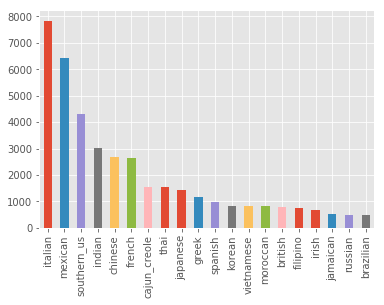

In [6]:
trainData['cuisine'].value_counts().plot(kind='bar')

Creating a table showing the 10 most common ingredients for each cuisine.

In [7]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [8]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


We can see from the above that the presence of salt tells us very little, but something like fish sauce can narrow down the probable cuisines considerably. To see how big this effect is, we visualise the percentage of recipes that our most common ingredients are found in, for each cuisine.

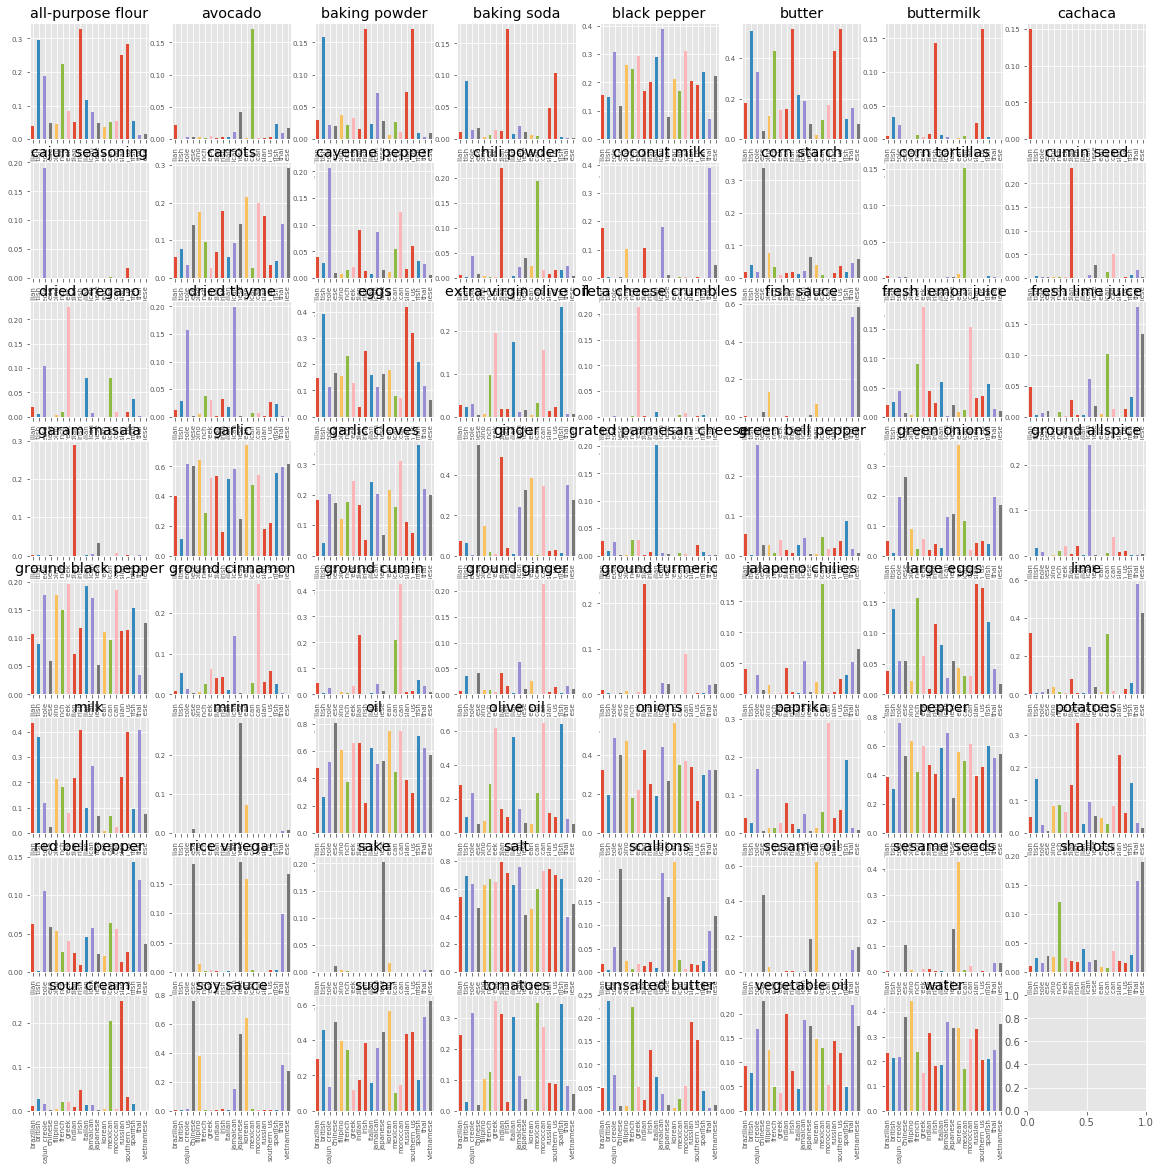

In [9]:
import numpy as np

unique = np.unique(top10.values.ravel())
trainData['all_ingredients'] = trainData['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = trainData['all_ingredients'].str.contains(ingredient)
    #indices = any(ingredient in s for s in trainData['ingredients'])
    relative_freq = (trainData[indices]['cuisine'].value_counts() / trainData['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


This indicates the above statement in a more understandable form - ingredients like water, butter and oil don't do much to differentiate between cuisines, whereas sake, feta cheese and garam masala are exceptionally informative.

This is, perhaps, not too surprising, and does indicate that a Naive Bayes classifier should perform very well on this dataset. 

### Section 3: Classifier Implementation

On the single fold of data tested (seed=37), the six classifiers implemented below achieved the following accuracy. Benchmarks are shown in brackets:

**KNN** - 64.44% *(60.75)* <br>
**Decision Tree** - 63.78% *(62.59)* <br>
**Naive Bayes** - 72.57% *(73.25)* <br>
**Random Forest** - 71.16% *(74.13)* <br>
**Logistic Regression** - 78.37% *(81.25)* <br>
**SVM (LinearSVC)** - 77.05% *(81.32)* <br>

For reference, on the test set a score of 82.07% would have been sufficient for a Top-10 placement, while the competition winner scored 83.02%.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(trainData['all_ingredients'], trainData['cuisine'], test_size=0.2, random_state=37)

#### At this point we are splitting all of the ingredients into 1 and 2 word ngrams


In [12]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_vec = cv.fit_transform(X_train.values)
X_test_vec = cv.transform(X_test.values)
X_train_vec.shape

(31819, 10000)

In [13]:
X_test_vec.shape

(7955, 10000)

In [14]:
print(list(cv.vocabulary_.keys())[:100])

['tomato', 'sauce', 'ground', 'black', 'pepper', 'garlic', 'scallions', 'chipotles', 'in', 'adobo', 'avocado', 'dried', 'thyme', 'instant', 'white', 'rice', 'cilantro', 'leaves', 'coconut', 'milk', 'water', 'red', 'beans', 'chopped', 'celery', 'skinless', 'chicken', 'thighs', 'onions', 'lime', 'zest', 'juice', 'wedges', 'salt', 'carrots', 'tomato sauce', 'sauce ground', 'ground black', 'black pepper', 'pepper garlic', 'garlic scallions', 'chipotles in', 'in adobo', 'dried thyme', 'white rice', 'rice cilantro', 'cilantro leaves', 'leaves coconut', 'coconut milk', 'milk water', 'water red', 'red beans', 'beans chopped', 'chopped celery', 'skinless chicken', 'chicken thighs', 'onions lime', 'lime zest', 'lime juice', 'juice lime', 'lime wedges', 'wedges salt', 'salt carrots', 'tomato sauce ground', 'sauce ground black', 'ground black pepper', 'black pepper garlic', 'chipotles in adobo', 'cilantro leaves coconut', 'leaves coconut milk', 'coconut milk water', 'lime juice lime', 'lime wedges

The below encodes the labels, mapping brazilian:vietnamese -> 0:19

Lastly it's worth checking our validation fold has a representative number of each cuisine in the set. We will of course perform later refolding and validation, but don't want to invalidate the results we'll be commenting on. The graph appears to be showing roughly the same proportions as present in the initial trainData set, so we can proceed.

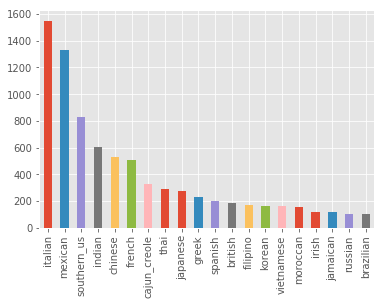

In [15]:
y_test.value_counts().plot(kind='bar')

#### Section 3.1: KNN Classifer

#### This is a modification to the fit, using the original train set labels rather than label encoder


In [16]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_vec, y_train)

neigh.score(X_test_vec, y_test)

0.5423004399748586

In [17]:
#this is for the classification report y labels
cuisines = trainData['cuisine'].value_counts(sort=False).index
cuisines

Index(['jamaican', 'japanese', 'southern_us', 'filipino', 'korean', 'greek',
       'mexican', 'thai', 'irish', 'brazilian', 'vietnamese', 'cajun_creole',
       'french', 'british', 'russian', 'moroccan', 'spanish', 'italian',
       'indian', 'chinese'],
      dtype='object')

In [18]:
type(cuisines)

pandas.core.indexes.base.Index

In [19]:
#this is for the classification report y target_names
cuisineslist = cuisines.tolist()

In [20]:
neigh_pred = neigh.predict(X_test_vec)
print(classification_report(y_test, neigh_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

    jamaican       0.91      0.18      0.30       117
    japanese       0.30      0.65      0.41       276
 southern_us       0.53      0.55      0.54       828
    filipino       0.45      0.36      0.40       171
      korean       0.79      0.36      0.49       165
       greek       0.73      0.21      0.33       229
     mexican       0.76      0.71      0.73      1331
        thai       0.92      0.38      0.54       292
       irish       0.48      0.18      0.26       121
   brazilian       0.41      0.32      0.36       102
  vietnamese       0.80      0.23      0.35       163
cajun_creole       0.85      0.29      0.43       327
      french       0.31      0.47      0.37       508
     british       0.26      0.17      0.20       184
     russian       0.20      0.01      0.02       104
    moroccan       0.78      0.18      0.30       152
     spanish       0.82      0.04      0.08       201
     italian       0.48    

#### Section 3.2: Decision Tree Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [21]:
from sklearn import tree

dec = tree.DecisionTreeClassifier()
dec.fit(X_train_vec, y_train)

dec.score(X_test_vec, y_test)

0.6388434946574482

In [22]:
dec_pred = dec.predict(X_test_vec)
print(classification_report(y_test, dec_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

    jamaican       0.58      0.44      0.50       117
    japanese       0.60      0.58      0.59       276
 southern_us       0.59      0.60      0.60       828
    filipino       0.47      0.43      0.45       171
      korean       0.64      0.62      0.63       165
       greek       0.56      0.52      0.54       229
     mexican       0.81      0.84      0.82      1331
        thai       0.63      0.61      0.62       292
       irish       0.39      0.33      0.36       121
   brazilian       0.56      0.43      0.49       102
  vietnamese       0.54      0.50      0.52       163
cajun_creole       0.60      0.56      0.58       327
      french       0.41      0.44      0.42       508
     british       0.30      0.23      0.26       184
     russian       0.22      0.17      0.19       104
    moroccan       0.52      0.56      0.54       152
     spanish       0.34      0.32      0.33       201
     italian       0.71    

Code courtesy of Stack Overflow - aim is to convert the above decision tree into a pythonic if-else statement so we can examine the decisions being made. Output is considerably too lengthy for easy reading, but we can see the low entropy of outputs at nearly all of the leaf nodes, indicating this tree is probably overfitting.

In [23]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [24]:
tree_to_code(dec,cv.get_feature_names())

def tree(achiote, acting, acting baking, acting baking powder, active, active dry, active dry yeast, added, added diced, added diced tomatoes, adobo, adobo ground, adobo sauce, agave, agave nectar, aged, ale, alfredo, alfredo sauce, all, all purpose, all purpose flour, all purpose unbleached, allspice, allspice berries, allspice ground, allspice ground cinnamon, almond, almond extract, almond flour, almond milk, almond paste, almonds, almonds butter, almonds ground, almonds large, almonds salt, almonds unsalted, almonds unsalted butter, amaretto, amchur, american, american cheese, aminos, anaheim, anaheim chile, ancho, ancho chile, ancho chile pepper, ancho powder, anchovies, anchovy, anchovy fillets, anchovy paste, and, and carrots, and drain, and drained, and fat, and fat free, and ground, and ground black, andouille, andouille sausage, andouille sausage ground, angel, angel hair, anise, anise cinnamon, anise cinnamon sticks, anise seed, annatto, apple, apple cider, apple cider vineg

                                                                                                                                                                          return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                      else:  # if lemon > 0.5
                                                                                                                                                                        if zest <= 0.5:
                                                                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]]
                                                                                                                                                

                                                                                                                                                                          else:  # if salt coconut > 0.5
                                                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                                                                                        else:  # if milk granulated > 0.5
                                                                                                                                                                          return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                 

                                                                                                                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                                                                                                else:  # if water > 0.5
                                                                                                                                                                                  if salt <= 0.5:
                                                                                                                                                                                    if onions black <= 0.5:
                                                                                                                                                     

                                                                                                                    else:  # if semi sweet chocolate > 0.5
                                                                                                                      return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                  else:  # if eggs all purpose > 0.5
                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                              else:  # if ice > 0.5
                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
     

                                                                                                                                                                                                                  else:  # if flour salt > 0.5
                                                                                                                                                                                                                    return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                                                              else:  # if eggs all > 0.5
                                                                                                                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0

   0.  0.]]
                                                                                else:  # if parsley > 0.5
                                                                                  return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                              else:  # if mayonaise salt > 0.5
                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                            else:  # if vinegar cucumber > 0.5
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]
                                                                          else:  # if garlic > 0.5
                                                                            if garlic cloves <= 0.5:
       

                                                                          if sweetened <= 0.5:
                                                                            if yukon <= 0.5:
                                                                              if pecan <= 0.5:
                                                                                if light corn <= 0.5:
                                                                                  if whites all <= 0.5:
                                                                                    if sugar dry <= 0.5:
                                                                                      if sliced almonds <= 0.5:
                                                                                        if salt <= 0.5:
                                                                                          if yolks <= 0.5:
                                                                                   

                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                  else:  # if garlic cloves > 0.5
                                                                                    return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if dal > 0.5
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                          else:  # if tomatoes > 0.5
                                                                            if seasoning <= 0.5:
                                                                              if pepper <= 0.5:
                                   

                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                              else:  # if onion > 0.5
                                                                if bok choy <= 0.5:
                                                                  if chili paste <= 0.5:
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                  else:  # if chili paste > 0.5
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if bok choy > 0.5
                                                                  return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  

   0.  0.]]
                                                                                                                      else:  # if butter milk > 0.5
                                                                                                                        if freshly ground pepper <= 0.5:
                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                                        else:  # if freshly ground pepper > 0.5
                                                                                                                          return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                    else:  # if marshmallows 

                                                                          else:  # if egg yolks > 0.5
                                                                            if milk salt <= 0.5:
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]]
                                                                            else:  # if milk salt > 0.5
                                                                              if milk salt sugar <= 0.5:
                                                                                return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                              else:  # if milk salt sugar > 0.5
                                                                                return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                             

                                                                                                return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            else:  # if feta cheese crumbles > 0.5
                                                                                              return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                          else:  # if butter hot sauce > 0.5
                                                                                            return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if bean > 0.5
                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

                                                                                      else:  # if meal large > 0.5
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                                    else:  # if water unsalted > 0.5
                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                                  else:  # if milk chocolate > 0.5
                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                else:  # if vegetables salt > 0.5
                                                                    

                                                                    return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  else:  # if all > 0.5
                                                                    return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if milk baking > 0.5
                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                                                            else:  # if irish > 0.5
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                          else:  # if of tartar large > 0.5
                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0

                                                                    else:  # if eggs > 0.5
                                                                      if salt vanilla <= 0.5:
                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                      else:  # if salt vanilla > 0.5
                                                                        return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if starch sugar > 0.5
                                                                  if egg <= 0.5:
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  else:  # if egg > 0.5
                         

   0.  0.]]
                                          else:  # if leaves vegetable > 0.5
                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                    else:  # if tomatoes > 0.5
                                      if dried <= 0.5:
                                        if ground beef <= 0.5:
                                          if white <= 0.5:
                                            if garlic cloves <= 0.5:
                                              if fresh <= 0.5:
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if fresh > 0.5
                                                if greek style plain <= 0.5:
                                                  if purpose flour <= 0.5:
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0

                                                                            if sugar chili <= 0.5:
                                                                              if butter cinnamon <= 0.5:
                                                                                if powder low <= 0.5:
                                                                                  if pinenuts <= 0.5:
                                                                                    if mozzarella <= 0.5:
                                                                                      if tomato <= 0.5:
                                                                                        if mustard garlic <= 0.5:
                                                                                          if butter cream cheese <= 0.5:
                                                                                            if milk heavy <= 0.5:
                                 

                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]]
                            else:  # if sauce > 0.5
                              if ground <= 0.5:
                                return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                              else:  # if ground > 0.5
                                if ancho powder <= 0.5:
                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                else:  # if ancho powder > 0.5
                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                          else:  # if poblano > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]]
                        else:  # if beans > 0.5
                          if chicken <= 0.5:
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                            else:  # if sugar > 0.5
                              return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. 11.]]
                          else:  # if rice scallions > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]
                      else:  # if water > 0.5
                        if shrimp <= 0.5:
                          if fresh <= 1.5:
                            if chicken breasts <= 0.5:
                              if sugar <= 0.5:
                                if cucumber <= 0.5:
                                  if beef <= 0.5:
                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0.]]
                                  else:  # if beef > 0.5
                                    if wedges <= 0.5:
           

                                                                                            return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                          else:  # if black beans > 0.5
                                                                                            return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                      else:  # if sausages > 0.5
                                                                                        if black <= 0.5:
                                                                                          return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if black > 0.5
                                                               

                                                if ground <= 0.5:
                                                  if fennel <= 0.5:
                                                    if black <= 0.5:
                                                      if chicken stock <= 0.5:
                                                        if chopped garlic <= 0.5:
                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9. 0. 0.]]
                                                        else:  # if chopped garlic > 0.5
                                                          return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if chicken stock > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if black > 0.5


                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                      else:  # if water > 0.5
                                        if leaves <= 0.5:
                                          if shoulder <= 1.0:
                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if shoulder > 1.0
                                            return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                        else:  # if leaves > 0.5
                                          if water salt <= 0.5:
                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                          else:  # if water salt > 0.5
                                            return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

                                    if corn <= 0.5:
                                      if sharp cheddar <= 0.5:
                                        if mozzarella <= 0.5:
                                          if tomato paste <= 0.5:
                                            if virgin olive <= 0.5:
                                              if cream <= 0.5:
                                                if potatoes <= 0.5:
                                                  if white cheddar <= 0.5:
                                                    if sausage olive <= 0.5:
                                                      if ginger <= 0.5:
                                                        if chicken breasts olive <= 0.5:
                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0.]]
                                                        else:  # if chicken breasts olive > 0.5
                    

                                  else:  # if sauce > 0.5
                                    if fresh sugar <= 0.5:
                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                    else:  # if fresh sugar > 0.5
                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                else:  # if red > 1.5
                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                            else:  # if masala > 0.5
                              if ground turmeric <= 0.5:
                                return [[0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                              else:  # if ground turmeric > 0.5
                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if hanout > 0.5
         

                                                                                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                                                                                          else:  # if fat yogurt > 0.5
                                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                                                                                        else:  # if harissa > 0.5
                                                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0.

                        return [[0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                  else:  # if virgin olive oil > 0.5
                    if ground <= 0.5:
                      if hot <= 0.5:
                        if clove <= 0.5:
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0. 0. 0.]]
                        else:  # if clove > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                      else:  # if hot > 0.5
                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                    else:  # if ground > 0.5
                      return [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                else:  # if oregano > 0.5
                  if harissa <= 0.5:
                    if fennel seeds <= 0.5:
                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9. 0. 0. 0. 0. 0. 0.]]
 

                                                      else:  # if hot pepper > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if round > 0.5
                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if powder soy sauce > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if ground > 0.5
                                                  if thyme <= 0.5:
                                                    if white sugar <= 0.5:
                                                      if chopped cilantro <= 0.5:
                                                        if hot <= 0.5:
             

                                                    return [[0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if cloves brown sugar > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if wine vinegar > 0.5
                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                          else:  # if ramen noodles > 0.5
                                            if chicken <= 0.5:
                                              if sriracha <= 0.5:
                                                return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if sriracha > 0.5
                                                if garlic <= 1.0:
      

                          return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if green onions > 0.5
                        if skinless chicken breasts <= 0.5:
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]
                        else:  # if skinless chicken breasts > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                  else:  # if sake > 0.5
                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]]
                else:  # if thyme > 0.5
                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
            else:  # if corn starch > 0.5
              if fish <= 0.5:
                if coconut milk <= 0.5:
                  if sake <= 0.5:
                    if corn syrup <= 0.5:
                      if lumpia <= 0.5:
                        if dashi <= 0.5:

                                                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                                                    else:  # if chicken flavor > 0.5
                                                                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                  else:  # if powder rice > 0.5
                                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                            

                                                                                      if corn <= 0.5:
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                      else:  # if corn > 0.5
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]]
                                                                                  else:  # if beans large > 0.5
                                                                                    if cheese <= 0.5:
                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                    else:  # if chee

#### Section 3.3: Naive Bayes Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [25]:
from sklearn.naive_bayes import MultinomialNB

bayes = MultinomialNB()
#todense() method used to coerce ndarray from csr (sparse) to dense format
#only seemed to be throwing errors on the training matrix, unsure why
bayes.fit(X_train_vec.todense(), y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
bayes.score(X_test_vec.todense(), y_test)

0.7104965430546826

In [27]:
bayes_pred = bayes.predict(X_test_vec.todense())
print(classification_report(y_test, bayes_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

    jamaican       0.74      0.53      0.62       117
    japanese       0.77      0.61      0.68       276
 southern_us       0.58      0.70      0.63       828
    filipino       0.72      0.57      0.64       171
      korean       0.77      0.75      0.76       165
       greek       0.55      0.65      0.59       229
     mexican       0.92      0.85      0.88      1331
        thai       0.71      0.78      0.74       292
       irish       0.56      0.43      0.49       121
   brazilian       0.61      0.39      0.48       102
  vietnamese       0.65      0.53      0.59       163
cajun_creole       0.57      0.78      0.66       327
      french       0.46      0.55      0.50       508
     british       0.32      0.33      0.32       184
     russian       0.44      0.27      0.34       104
    moroccan       0.66      0.81      0.73       152
     spanish       0.42      0.55      0.47       201
     italian       0.85    

#### Section 3.4: Random Forest Classifer

In [28]:
from sklearn.ensemble import RandomForestClassifier

frst = RandomForestClassifier(random_state=37)
frst.fit(X_train_vec, y_train)

frst.score(X_test_vec, y_test)

0.6936517913262099

In [29]:
frst_pred = frst.predict(X_test_vec)
print(classification_report(y_test, frst_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

    jamaican       0.83      0.38      0.52       117
    japanese       0.73      0.55      0.63       276
 southern_us       0.62      0.66      0.64       828
    filipino       0.68      0.45      0.54       171
      korean       0.78      0.56      0.65       165
       greek       0.68      0.55      0.60       229
     mexican       0.83      0.89      0.86      1331
        thai       0.71      0.67      0.69       292
       irish       0.49      0.28      0.36       121
   brazilian       0.53      0.38      0.45       102
  vietnamese       0.73      0.37      0.50       163
cajun_creole       0.69      0.65      0.67       327
      french       0.46      0.49      0.47       508
     british       0.43      0.24      0.31       184
     russian       0.60      0.14      0.23       104
    moroccan       0.79      0.53      0.64       152
     spanish       0.75      0.22      0.34       201
     italian       0.69    

#### Section 3.5: Logistic Regression Classifer

In [30]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_vec, y_train)

logistic.score(X_test_vec, y_test)

0.7705845380263985

Text(0.5,64.6,'Predicted label')

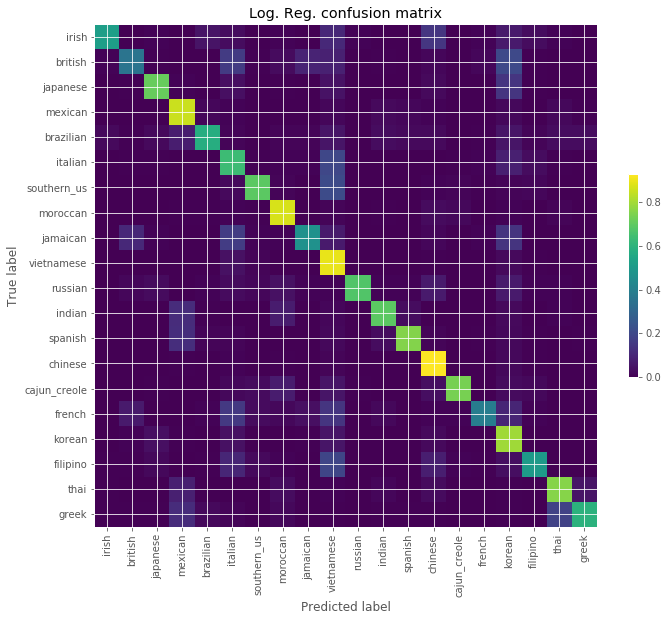

In [33]:
plt.figure(figsize=(10, 10))

log_cm = confusion_matrix(y_test, logistic.predict(X_test_vec))
log_cm_normalized = log_cm.astype('float') / log_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(log_cm_normalized, interpolation='nearest')
plt.title("Log. Reg. confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [34]:
log_pred = logistic.predict(X_test_vec)
print(classification_report(y_test, log_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.62      0.47      0.54       121
     british       0.59      0.36      0.45       184
    japanese       0.82      0.70      0.75       276
     mexican       0.91      0.93      0.92      1331
   brazilian       0.75      0.52      0.61       102
     italian       0.79      0.90      0.84      1550
 southern_us       0.70      0.80      0.75       828
    moroccan       0.83      0.74      0.78       152
    jamaican       0.91      0.68      0.77       117
  vietnamese       0.81      0.60      0.69       163
     russian       0.68      0.39      0.50       104
      indian       0.87      0.87      0.87       605
     spanish       0.65      0.51      0.57       201
     chinese       0.78      0.85      0.81       529
cajun_creole       0.79      0.71      0.75       327
      french       0.57      0.64      0.60       508
      korean       0.82      0.76      0.79       165
    filipino       0.73    

#### Note altered cuisines of concern

Although the raw accuracy score looks good, the confusion matrix and particularly the analysis of the recall show a different story for some cuisines. Spanish, Russian and British dishes are more likely to be classified as other cuisines than they are themselves, indicating that there may be few stand-out ingredients for these cuisines.

#### Section 3.6: SVM Classifer

In [35]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=37)
lsvc.fit(X_train_vec, y_train)

lsvc.score(X_test_vec, y_test)

0.7586423632935261

Text(0.5,64.6,'Predicted label')

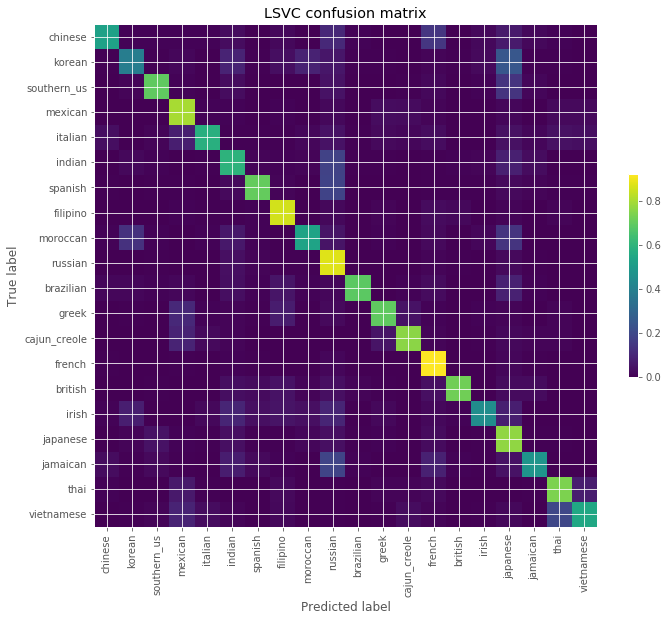

In [48]:
plt.figure(figsize=(10, 10))

lsvc_cm = confusion_matrix(y_test, lsvc.predict(X_test_vec))
lsvc_cm_normalized = lsvc_cm.astype('float') / lsvc_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(lsvc_cm_normalized, interpolation='nearest')
plt.title("LSVC confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [36]:
lsvc_pred = lsvc.predict(X_test_vec)
print(classification_report(y_test, lsvc_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.52      0.49      0.50       121
     british       0.57      0.43      0.49       184
    japanese       0.77      0.68      0.73       276
     mexican       0.90      0.91      0.90      1331
   brazilian       0.68      0.53      0.60       102
     italian       0.81      0.87      0.84      1550
 southern_us       0.70      0.74      0.72       828
    moroccan       0.76      0.70      0.73       152
    jamaican       0.74      0.68      0.71       117
  vietnamese       0.70      0.60      0.64       163
     russian       0.57      0.41      0.48       104
      indian       0.84      0.85      0.85       605
     spanish       0.51      0.48      0.49       201
     chinese       0.77      0.81      0.79       529
cajun_creole       0.73      0.69      0.71       327
      french       0.55      0.60      0.58       508
      korean       0.78      0.75      0.76       165
    filipino       0.66    

#### Bonus section: implementing pipelines from andrew_bag_of_words to compare results

In [55]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),
                         ])

text_clf_svm.fit(X_train, y_train)
text_clf_svm.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.7063482086737901

In [183]:
pipe_svm_pred = text_clf_svm.predict(X_test)
print(classification_report(y_test, pipe_svm_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.75      0.26      0.39       102
     mexican       0.57      0.11      0.18       184
 southern_us       0.71      0.67      0.69       327
      indian       0.65      0.87      0.74       529
     chinese       0.82      0.23      0.36       171
      french       0.63      0.38      0.47       508
cajun_creole       0.76      0.54      0.63       229
        thai       0.74      0.89      0.81       605
    japanese       0.62      0.23      0.34       121
       greek       0.68      0.93      0.78      1550
     spanish       0.84      0.44      0.57       117
      korean       0.80      0.61      0.69       276
  vietnamese       0.76      0.45      0.57       165
    moroccan       0.82      0.93      0.87      1331
     british       0.80      0.49      0.60       152
    filipino       0.66      0.26      0.37       104
       irish       0.61      0.74      0.67       828
    jamaican       0.66    

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_nb.fit(X_train, y_train)
pipe_nb.score(X_test,y_test)

0.6764299182903835

In [56]:
pipe_nb_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, pipe_nb_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.59      0.90      0.72       529
      korean       0.93      0.38      0.54       165
 southern_us       0.50      0.80      0.61       828
     mexican       0.80      0.92      0.86      1331
     italian       0.66      0.91      0.76      1550
      indian       0.76      0.90      0.83       605
     spanish       0.96      0.11      0.20       201
    filipino       0.95      0.11      0.20       171
    moroccan       0.96      0.34      0.50       152
     russian       1.00      0.02      0.04       104
   brazilian       1.00      0.19      0.31       102
       greek       0.89      0.33      0.48       229
cajun_creole       0.80      0.50      0.61       327
      french       0.53      0.42      0.47       508
     british       0.81      0.07      0.13       184
       irish       0.93      0.11      0.19       121
    japanese       0.94      0.57      0.71       276
    jamaican       0.95    

This is actually the most interesting result so far. The high precision and horrendous recall on Spanish, Filipino, British, Irish and Jamaican suggest that the classifier is barely predicting these cuisines at all. That said, the f-score is very high for other cuisines such as Mexican, Indian, Italian, Chinese, suggesting that this could be used as part of a One vs All classifier ensemble, specifically for dealing with those cuisines.

Text(0.5,64.6,'Predicted label')

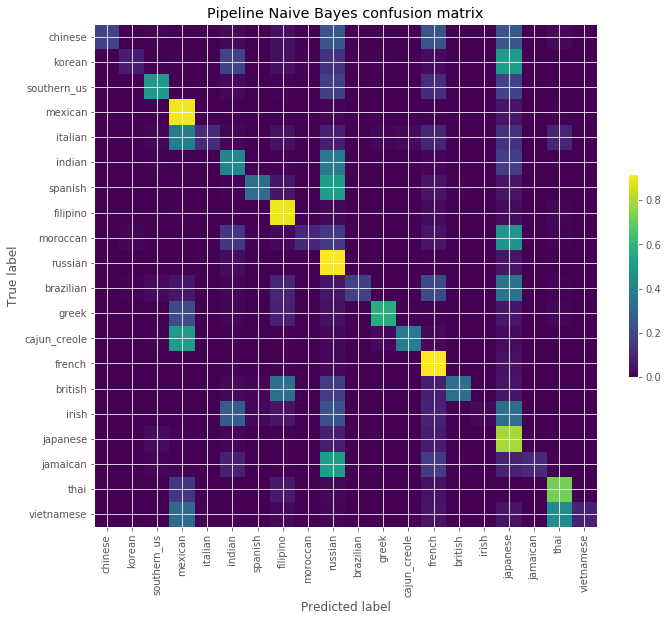

In [57]:
plt.figure(figsize=(10, 10))

pipe_nb_cm = confusion_matrix(y_test, pipe_nb.predict(X_test))
pipe_nb_cm_normalized = pipe_nb_cm.astype('float') / pipe_nb_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(pipe_nb_cm_normalized, interpolation='nearest')
plt.title("Pipeline Naive Bayes confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')